In [2]:
import pylab 

Focal length of left camera: 359.13296707252016
Focal length of right camera: 343.49788568657203
Average depth in the ROI: 2.21 meters


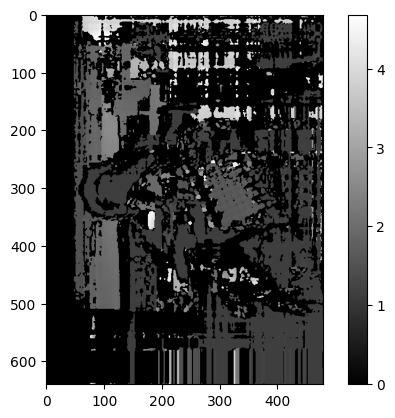

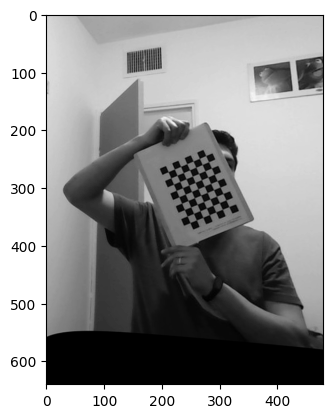

In [17]:
import cv2 as cv
import numpy as np
import os



focal_length_pixels = 359  # Example focal length in pixels
baseline_meters = 0.15  # Example baseline in meters

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def load_stereo_calibration(filename):
    # Load stereo calibration parameters from an XML file
    cv_file = cv.FileStorage(filename, cv.FILE_STORAGE_READ)
    cameraMatrix1 = cv_file.getNode("cameraMatrix1").mat()
    distCoeffs1 = cv_file.getNode("distCoeffs1").mat()
    cameraMatrix2 = cv_file.getNode("cameraMatrix2").mat()
    distCoeffs2 = cv_file.getNode("distCoeffs2").mat()
    R = cv_file.getNode("R").mat()
    T = cv_file.getNode("T").mat()
    cv_file.release()
    focal_length_left = cameraMatrix1[0, 0]
    focal_length_right = cameraMatrix2[0, 0]
    focal_length_pixels = focal_length_left
    print("Focal length of left camera:", focal_length_left)
    print("Focal length of right camera:", focal_length_right)
    return cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T

ensure_dir('images/Right')
ensure_dir('images/Left')

# Load stereo calibration data
calib_filename = 'stereo_calibration_data.xml'  # Update this path as needed
cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T = load_stereo_calibration(calib_filename)

# Open the cameras



# cap_left.set(cv.CAP_PROP_AUTOFOCUS, 0)
# cap_right.set(cv.CAP_PROP_AUTOFOCUS, 0)

# cap_left.set(cv.CAP_PROP_FOCUS, 50)
# cap_right.set(cv.CAP_PROP_FOCUS, 50)

# # Wait for cameras to initialize
# ret_left, frame_left = cap_left.read()
# ret_right, frame_right = cap_right.read()

frame_right = cv.imread(r"images\Right\20240210_194043.jpg")
frame_left = cv.imread(r"images\Left\20240210_194043.jpg")


# Compute rectification transforms for both cameras
R1, R2, P1, P2, Q, _, _ = cv.stereoRectify(
    cameraMatrix1, distCoeffs1,
    cameraMatrix2, distCoeffs2,
    frame_left.shape[:2], R, T, alpha=0)

map1_left, map2_left = cv.initUndistortRectifyMap(
    cameraMatrix1, distCoeffs1, R1, P1,
    frame_left.shape[:2], cv.CV_16SC2)
map1_right, map2_right = cv.initUndistortRectifyMap(
    cameraMatrix2, distCoeffs2, R2, P2,
    frame_right.shape[:2], cv.CV_16SC2)

# StereoSGBM Matcher for disparity calculation
stereo = cv.StereoSGBM_create(
    # numDisparities=16, blockSize=15
    minDisparity=0,
    numDisparities=16*3,
    blockSize=5,
    P1=8 * 3 * 5**2,
    P2=32 * 3 * 5**2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=63,
    mode=cv.STEREO_SGBM_MODE_HH4
)

while True:
    # Capture frames from both cameras
    frame_right = cv.imread(r"images\Right\20240210_194043.jpg")
    frame_left = cv.imread(r"images\Left\20240210_194043.jpg")

    # Convert to grayscale for disparity calculation
    gray_left = cv.cvtColor(frame_left, cv.COLOR_BGR2GRAY)
    gray_right = cv.cvtColor(frame_right, cv.COLOR_BGR2GRAY)

    # # Rectify images
    rectified_left = cv.remap(gray_left, map1_left, map2_left, cv.INTER_CUBIC)
    rectified_right = cv.remap(gray_right, map1_right, map2_right, cv.INTER_CUBIC)

    # Compute the disparity map
    disparity = stereo.compute(rectified_left, rectified_right).astype(np.float32) / 16.0

    depth_map = np.zeros_like(disparity)
    non_zero_disparity = disparity > 0  # Avoid division by zero
    depth_map[non_zero_disparity] = (focal_length_pixels * baseline_meters) / disparity[non_zero_disparity]

    roi_size = 100  # Size of the square's side
    height, width = depth_map.shape
    center_x, center_y = width // 2, height // 2
    roi = depth_map[center_y - roi_size // 2:center_y + roi_size // 2,
                    center_x - roi_size // 2:center_x + roi_size // 2]

    # Calculate the average depth in the ROI
    average_depth = np.mean(roi[roi > 0])  # Ignore zero values
    print(f"Average depth in the ROI: {average_depth:.2f} meters")

    pylab.plot()
    depth_map[depth_map>np.quantile(depth_map[non_zero_disparity],0.90)] = 0
    depth_map[depth_map<np.quantile(depth_map[non_zero_disparity],0.10)] = 0
    pylab.imshow(depth_map, cmap='gray')
    pylab.colorbar()
    pylab.show()

    pylab.plot()
    pylab.imshow(rectified_right, cmap='gray')
    pylab.show()

    break

# Release video capture objects and close windows


In [4]:
depth_map.min(), depth_map.max()

(0.0, 4.4874997)